In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras.utils import to_categorical

# Functions

## Classes distribution

In [ ]:
def display_pie_chart(df, column_name, title=None, filename=None):
    """ Function to display the percentage ratio of column (with the name column_name) content 
    Args:
        1) df - the original dataframe that contains the required information
        2) column_name - the name of the df dataframe column whose percentage values are to be found
        3) title - the title of the graph
        4) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        None, but plots graph
    """
    # Calculate the percentage of each activity in original_df
    activity_percentages_df = df[column_name].value_counts(normalize=True) * 100

    plt.figure(figsize=(12, 6))

    # Plot pie chart for df
    sns.set_palette("Set3")
    plt.pie(activity_percentages_df, labels=activity_percentages_df.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)

    # Adjust layout
    plt.tight_layout()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()

In [ ]:
def display_pie_charts(first_df, second_df, column, first_chart_title='First DataFrame', second_chart_title='Second DataFrame', filename=None):
    """Function for displaying the ratio of column content between two dataframes in the form of pie charts
    Args:
        1) first_df - the original dataframe that contains the required information
        2) second_df - a dataframe that contains the results of windowing 
        3) column - the name of the dataframe column whose percentage values are to be found
        4) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        None; just builds a pie chart to display the ratio of column contents between two dataframes
    """
    # Calculate the percentage of each activity in first_df
    activity_percentages_first_df = first_df[column].value_counts(normalize=True) * 100

    # Calculate the percentage of each activity in second_df
    activity_percentages_second_df = second_df[column].value_counts(normalize=True) * 100

    # Create subplots for pie charts
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot pie chart for df
    sns.set_palette("Set3")
    axes[0].pie(activity_percentages_first_df, labels=activity_percentages_first_df.index, autopct='%1.1f%%', startangle=140)
    axes[0].set_title(first_chart_title)

    # Plot pie chart for windowed_df
    sns.set_palette("Set3")
    axes[1].pie(activity_percentages_second_df, labels=activity_percentages_first_df.index, autopct='%1.1f%%', startangle=140)
    axes[1].set_title(second_chart_title)

    # Adjust layout
    plt.tight_layout()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()

## Model Training

In [ ]:
def plot_graphs(history, strings, filename=None):
    """Function to plot graphs for two training history parameters (eg accuracy and loss)
    Args:
        1) history - model training history
        2) strings - an array of names of history parameters (only the data of the first two history parameters specified in this array will be taken for graphing)
        3) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(history.history[strings[0]], label=strings[0])
    axes[0].plot(history.history[f"val_{strings[0]}"], label=f"val_{strings[0]}")
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel(strings[0])
    axes[0].legend()
    
    axes[1].plot(history.history[strings[1]], label=strings[1])
    axes[1].plot(history.history[f"val_{strings[1]}"], label=f"val_{strings[1]}")
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel(strings[1])
    axes[1].legend()
    
    if filename:
        plt.savefig(f"{filename}.png", bbox_inches='tight')
    plt.show()

# Read and prepare train, validation and test datasets

## Read train_data and test_data

In [ ]:
train_data = pd.read_csv('data/40_Hz/model_data/train_data.csv')
train_data.head()

In [ ]:
train_data.info()

In [ ]:
test_data = pd.read_csv('data/40_Hz/model_data/test_data.csv')
test_data.head()

In [ ]:
test_data.info()

## Add 'activity_number' column to train_data and test_data

In [ ]:
activity_dict = {'Squat': 0, 'Leg land': 1, 'Walk': 2, 'Lateral squat slide': 3, 'Jogging': 4}
train_data['activity_number'] = train_data['activity'].apply(lambda x: activity_dict[x])
test_data['activity_number'] = test_data['activity'].apply(lambda x: activity_dict[x])
train_data.head()

#### Check the contents of the column 'activity_number'

In [ ]:
train_data[train_data['activity'] == 'Leg land'][:2]

In [ ]:
train_data[train_data['activity'] == 'Walk'][:2]

In [ ]:
train_data[train_data['activity'] == 'Lateral squat slide'][:2]

In [ ]:
train_data[train_data['activity'] == 'Jogging'][:2]

## Split train_data and test_data into required datasets

### Split train_data into X_train, y_train, X_valid, y_valid  

#### View the distribution of classes before dividing the train_data dataset

In [ ]:
display_pie_chart(df=train_data, column_name='activity', title='Class label distribution')

In [ ]:
display_pie_chart(df=train_data, column_name='activity_number', title='Class label distribution')

#### Perform spliting

In [ ]:
X_train = pd.DataFrame()
y_train = []

X_valid = pd.DataFrame()
y_valid = []

counter = 0

for activity in train_data['activity'].unique():
    activity_data = train_data[train_data['activity'] == activity].copy()
    activity_data.reset_index(inplace=True)
    activity_data.drop('index', axis=1, inplace=True)
    split_index = int(0.8 * len(activity_data))
    if counter != 0:
        X_train = pd.concat([X_train, activity_data[activity_data.columns[:-2]][:split_index]])
    else:
        X_train = activity_data[activity_data.columns[:-2]][:split_index]
        
    y_train.extend(list(activity_data['activity_number'].values[:split_index]))
    
    
    if counter != 0:
        X_valid = pd.concat([X_valid, activity_data[activity_data.columns[:-2]][split_index:]])
    else:
        X_valid = activity_data[activity_data.columns[:-2]][split_index:]
        
    y_valid.extend(list(activity_data['activity_number'].values[split_index:]))
    
    counter += 1
    
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'len(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

#### View the distribution of classes after dividing the train_data dataset

In [ ]:
train_df = X_train.copy()
train_df['activity_number'] = y_train

valid_df = X_valid.copy()
valid_df['activity_number'] = y_valid

display_pie_charts(first_df=train_df, second_df=valid_df, column='activity_number', 
                   first_chart_title='Train_df class label distribution',
                   second_chart_title='Validation_df class label distribution', 
                   filename='graphs/train_valid_pie_charts')

### Split test_data into X_test, y_test

In [ ]:
display_pie_chart(df=test_data, column_name='activity_number', title='Class label distribution', filename='graphs/test_pie_chart')

In [ ]:
X_test = test_data[test_data.columns[:-2]]
y_test = test_data['activity_number'].values

print(f'len(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

# Model training

### View the sizes of the training, validation and test datasets

In [ ]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# Convert Label Encoded target data to one-hot encoded format
y_train_encoded = to_categorical(y_train)
y_valid_encoded = to_categorical(y_valid)
y_test_encoded = to_categorical(y_test)

print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'len(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

print(f'len(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

### Scale X_train, X_valid, X_test datasets

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### Train the NN model

In [192]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(80, activation='relu', input_shape=(len(X_train.columns), )))
model.add(tf.keras.layers.Dense(40, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='sigmoid'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
          
history = model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=10, validation_data=(X_valid_scaled, y_valid_encoded))
          
# evaluate the keras model
loss, accuracy = model.evaluate(X_test_scaled, y_test_encoded)
print(f'Accuracy: {accuracy*100:.2f}')

Epoch 1/10
144/144 [==============================] - 1s 2ms/step - loss: 1.2966 - accuracy: 0.5302 - val_loss: 0.7657 - val_accuracy: 0.9333
Epoch 2/10
144/144 [==============================] - 0s 2ms/step - loss: 0.5563 - accuracy: 0.9812 - val_loss: 0.4324 - val_accuracy: 0.9750
Epoch 3/10
144/144 [==============================] - 0s 2ms/step - loss: 0.3534 - accuracy: 0.9903 - val_loss: 0.2978 - val_accuracy: 0.9889
Epoch 4/10
144/144 [==============================] - 0s 2ms/step - loss: 0.2547 - accuracy: 0.9910 - val_loss: 0.2220 - val_accuracy: 0.9889
Epoch 5/10
144/144 [==============================] - 0s 2ms/step - loss: 0.1895 - accuracy: 0.9944 - val_loss: 0.1794 - val_accuracy: 0.9889
Epoch 6/10
144/144 [==============================] - 0s 2ms/step - loss: 0.1494 - accuracy: 0.9958 - val_loss: 0.1574 - val_accuracy: 0.9861
Epoch 7/10
144/144 [==============================] - 0s 2ms/step - loss: 0.1166 - accuracy: 0.9972 - val_loss: 0.1396 - val_accuracy: 0.9833
Epoch 

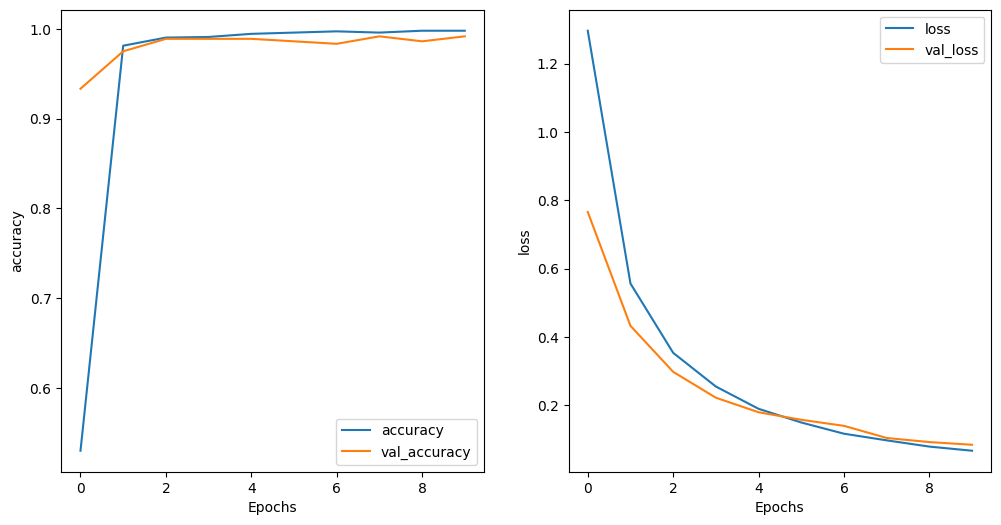

In [193]:
plt.rcdefaults()
plot_graphs(history=history, strings=['accuracy', 'loss'])

12/12 [==============================] - 0s 3ms/step


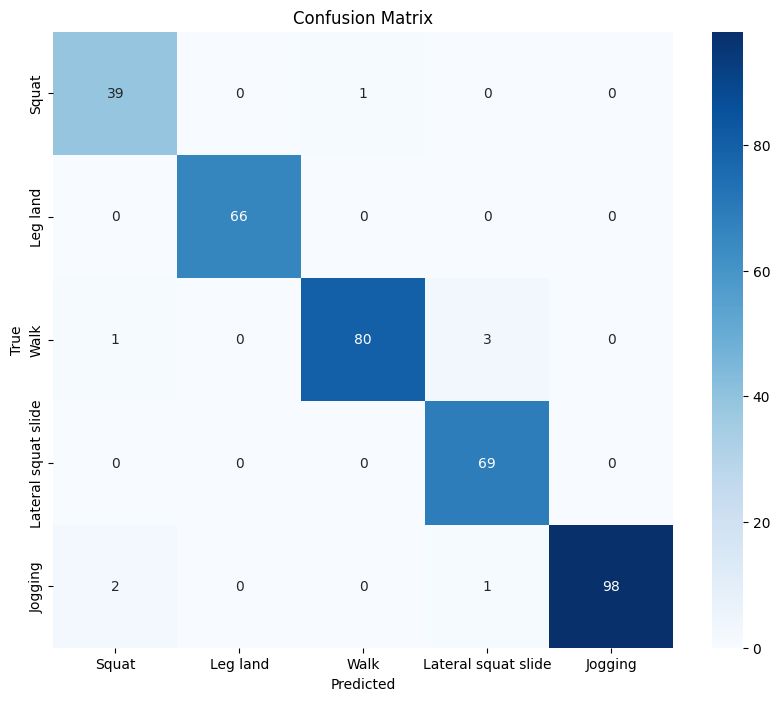

In [194]:
# Get predicted labels
y_pred_encoded = model.predict(X_test_scaled)
y_pred_labels = y_pred_encoded.argmax(axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Define class names
class_names = ['Squat', 'Leg land', 'Walk', 'Lateral squat slide', 'Jogging']

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Show the heatmap
plt.show()

In [195]:
# Calculate and print classification report
class_report = classification_report(y_test, y_pred_labels, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
                     precision    recall  f1-score   support

              Squat       0.93      0.97      0.95        40
           Leg land       1.00      1.00      1.00        66
               Walk       0.99      0.95      0.97        84
Lateral squat slide       0.95      1.00      0.97        69
            Jogging       1.00      0.97      0.98       101

           accuracy                           0.98       360
          macro avg       0.97      0.98      0.98       360
       weighted avg       0.98      0.98      0.98       360



In [196]:
for activity in test_data['activity'].unique():
    print(f"{activity}: {len(test_data[test_data['activity'] == activity])}")

Squat: 40
Leg land: 66
Walk: 84
Lateral squat slide: 69
Jogging: 101
